# SMART LASER NLP

## INDEX

1.2 IMPORTS

1.3 DATASET GATHERING AND CLEANING

1.4 DATASET ANALYSIS

1.5 VOCABULARY

1.6 RNN MODEL

1.7 TRAINING

1.8 MANUAL TESTING

2 Create my own dataset? I would like to try this. Creating my own template equations and text.

## IMPORTS

In [1]:
#Data management
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import itertools

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#System
import sys
import json
import unicodedata
import os
import time

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, GRU, LSTM, Dense, Dropout
from tensorflow.python.client import device_lib  #print(device_lib.list_local_devices())

#Algebra
import sympy
#import scipy

## DATASET GATHERING AND CLEANING

In [2]:
#Read the datasets. We will first use this subset instead of the bigger one (Dolphin18k) because this one is cleaner (only linear) and
#might be enough for our
def load_data():
    math_dataset = pd.read_excel('arithmeticquestionsDataset/arithmeticquestions.xlsx')
    math_dataset = math_dataset[['Question', 'Equation', 'Answer']]
    
    
    math_dataset['Question'] = math_dataset['Question'].apply(round_if_str2float)
    math_dataset['Equation'] = math_dataset['Equation'].apply(round_if_str2float)
    math_dataset['Answer'] = math_dataset['Answer'].apply(lambda x: round(x, 2))
    
    math_dataset.Question, math_dataset.Equation = numberMapping(math_dataset.Question, math_dataset.Equation)
    
    math_dataset = math_dataset.sample(frac=1).reset_index(drop=True)
    
    return math_dataset

#Round numbers on questions and equations to 3 decimal numbers.
def round_if_str2float(row):
    newStr = ''
    for el in row.split(' '):
        try: 
            el = float(el)
            el = round(el, 2)
            el = str(el)
            newStr = newStr + ' ' + el
        except (ValueError, TypeError) as er:
            newStr = newStr + ' ' + el
    return newStr

def unicodeToAscii(e):
    return ''.join(
        c for c in unicodedata.normalize('NFD', e)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeEquations(e):#lo usaba para el anterior dataset, no para este
    e = unicodeToAscii(e)
    # ensure each math symbol is it's own token
    e = "".join([ c if c.isalnum() else " {} ".format(c) for c in e])
    #Remove the unknowns part from the equation
    e = e[e.index(';') + 1:]
    #All characters in equation separated by a whitespace
    e = " ".join(e.split())

    return e

def numberMapping(input_tensor, target_tensor):#Esto será para sustituir los números del texto de los problemas por incógnitas n1, n2, n3, ... , nx. El modelo aprenderá mejor así. 
    variables = ['n1', 'n2', 'n3', 'n4', 'n5']
    numberMapping = {}
    
    for i, (inp, targ) in enumerate(zip(input_tensor, target_tensor)):
        numberMapping[i] = []
        newStr = ''
        n = 0
        for el in targ.split(' '):
            try: 
                el = str(float(el))# para que de error si no es convertible a float
                numberMapping[i].append(el)
                el = variables[n]
                n += 1
                
                newStr = newStr + ' ' + el
            except (ValueError, TypeError) as er:
                newStr = newStr + ' ' + el
                
        target_tensor[i] = newStr
        
        newStr = ''
        n = 0
        for el in inp.split(' '):
            try: 
                el = str(float(el))# para que de error si no es convertible a float
                for n in range(len(numberMapping[i])):
                    if el == numberMapping[i][n]:
                        el = variables[n]
                        n += 1
                        break
                
                newStr = newStr + ' ' + el
            except (ValueError, TypeError) as er:
                newStr = newStr + ' ' + el
                
        input_tensor[i] = newStr
        
        
    return input_tensor, target_tensor
    
    
    pass

def data_splitter(input_tensor, target_tensor, percentageToTrain):
    rowsToTrain = int(percentageToTrain*len(input_tensor))
    input_tensor_train = input_tensor[:rowsToTrain]
    input_tensor_test = input_tensor[rowsToTrain:]
    
    target_tensor_train = target_tensor[:rowsToTrain]
    target_tensor_test = target_tensor[rowsToTrain:]
    return input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test

#Dataset description
math_dataset = load_data()
math_dataset

C:\Users\Hermanos\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hermanos\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Question,Equation,Answer
0,There are n1 oak trees currently in the park...,X = n1 - n2,15.00
1,Dan had n1 peaches and 10.0 pears at his roa...,n1 + X = n2,71.00
2,Sandy had 36.0 pennies and n1 nickels in her...,X = n1 - n2,11.00
3,A construction company bought n1 tons of gra...,X = n1 + n2,14.02
4,Jason has n1 Pokemon cards . Alyssa bought n...,X = n1 - n2,452.00
5,There are n1 walnut trees and 12.0 orange tr...,X = n1 - n2,29.00
6,There are n1 pencils and n2 rulers in the dr...,X = n1 - n2,5.00
7,Benny received n1 dollars and 9.0 movie tick...,X = n1 - n2,47.00
8,Alyssa 's dog had puppies . She gave n1 to h...,X = n1 + n2,12.00
9,Greg and Sharon own neighboring cornfields ....,X = n1 - n2,0.30


## DATASET ANALYSIS

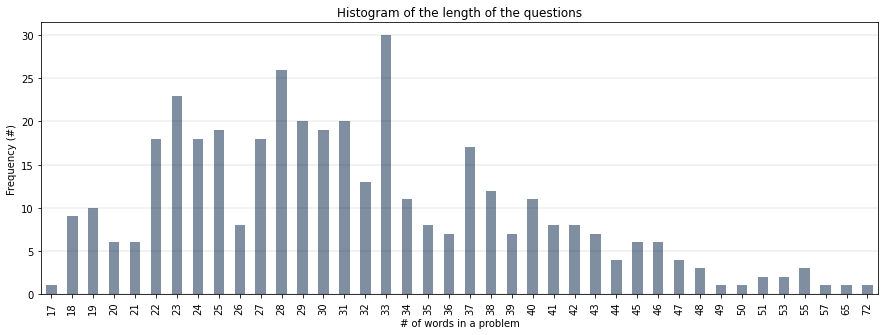

In [3]:
#Understanding the dataset through visualization

plt.figure(1, figsize=(15,5))
plt.title('Histogram of the length of the questions')
plt.xlabel('# of words in a problem')
plt.ylabel('Frequency (#)')
math_dataset['Question'].str.split().apply(len).value_counts().sort_index().plot(kind='bar', color='#7f8fa1')
plt.grid(color='black', linestyle='-', linewidth=0.1, axis='y')

## Vocabulary

In [4]:
SOS = 0 #Start Of Sentence
EOS = 1 #End Of Sentence


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} #Para pasar de palabra al indice donde se encuentra la palabra en el vocabulario
        self.word2count = {} #La cantidad de veces que aparece esa palabra
        self.index2word = {0: "SOS", 1: "EOS"} #Aqui se asigna a un indice una palabra única
        self.n_words = 2  #Número de palabras en el vocabulario. Se incluye SOS y EOS.

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
math_dataset = load_data()

#input_lang = Lang('text')
#target_lang = Lang('equations')
input_tensor = ['<start> ' + problem + ' <end>' for problem in math_dataset['Question']]
target_tensor = ['<start> ' + equation + ' <end>' for equation in math_dataset['Equation']]

#for inp, targ in zip(input_tensor, target_tensor):
#    input_lang.addSentence(inp)
#   target_lang.addSentence(targ)

#print(input_lang.n_words)
#print(target_lang.n_words)


C:\Users\Hermanos\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hermanos\Anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
def tokenize(lang):
    # Creating a tokenizer
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    
    # Building word indices
    lang_tokenizer.fit_on_texts(lang)
    
    # Tokenizing sentences
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    # Creating a reverse dictionary
    index2word = dict(map(reversed, lang_tokenizer.word_index.items()))

    

    
    return tensor, lang_tokenizer, index2word

# Function takes a tokenized sentence and returns the words
def seq2text(list_of_indices, index2word):
    # Looking up words in dictionary
    text = [index2word.get(word) for word in list_of_indices if index2word.get(word) != None]
    return text

input_tensor, inp_lang, inp_lang_index2word = tokenize(input_tensor)
target_tensor, targ_lang, targ_lang_index2word = tokenize(target_tensor)




input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = data_splitter(input_tensor, target_tensor, percentageToTrain=0.9)

BUFFER_SIZE = len(input_tensor_train)
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

## RNN Model

Usaremos un RecurrentNeuralNetwork-based seq2seq model. Con un encoder (Gated Recurrent Units) y decoder (Long Short-Term Memory)

-GRU:

    1) Update gate
    2) Reset gate
    3) New memory
    4) Hidden state
    

-LSTM:

    1) Input gate
    2) Forget gate
    3) Output gate
    4) New memory
    5) Final memory
    6) Hidden state

In [7]:
class GRUEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout):
        super(GRUEncoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        
        #self.dropout = Dropout(dropout)
        
    def call(self, x, hidden):
        #print('x preembed:',x)
        x = self.embedding(x)
        #print('x posembed:',x)
        output, state = self.gru(x, initial_state = hidden)
        
        #output = self.dropout(output)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class GRUDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout):
        super(GRUDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=0.5)
        #self.dropout = Dropout(dropout)
        self.fc = Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #a ver
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2])) #no se
        
        #output = self.dropout(output)
        
        output = self.fc(output)
        
        return output, state

class LSTMDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout):
        super(LSTMDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        #self.dropout = Dropout(dropout)
        self.fc = Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #a ver
        
        output, state, _ = self.lstm(x)
        
        
        output = tf.reshape(output, (-1, output.shape[2])) #no se
        
        #output = self.dropout(output)
        
        output = self.fc(output)
        
        return output, state

def setOptimizer(lr):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    return optimizer, loss_object

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


## Training and Validation

In [20]:
def _train(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

train = tf.function(_train)

def val(sentence):
    
    inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else inp_lang.word_index['what'] for i in sentence]##################################
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                     maxlen=input_tensor_test.shape[1],
                                                     padding='post')
    inputs = tf.convert_to_tensor(inputs)
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    result = []
    for t in range(target_tensor_test.shape[1]):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)

        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if predicted_id != None:
            result.append(predicted_id)
        

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence



def tryTheModel(units, learning_rate, BATCH_SIZE, EPOCHS, embedding_dim):

    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))#.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    
    ### TRAINING ###
    start = time.time()
    model_loss_train=[]
    for epoch in range(EPOCHS):

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(BATCH_SIZE)):
            try:
                batch_loss = train(inp, targ, enc_hidden)
            except (UnboundLocalError, ValueError):
                train = tf.function(_train)
                batch_loss = train(inp, targ, enc_hidden)
                
            total_loss += batch_loss

            #print('Training Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        model_loss_train.append(total_loss / (len(input_tensor_train)/BATCH_SIZE))
        # saving (checkpoint) the model
        checkpoint.save(file_prefix = checkpoint_prefix)

        print('Training Epoch {} Loss {:.8f}'.format(epoch + 1,
                                          total_loss / (len(input_tensor_train)/BATCH_SIZE)))

    
    
    plt.figure()
    plt.title("loss")
    plt.plot(model_loss_train, 'b-')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    minTrainLoss = min(model_loss_train)
    print("Min training loss : ", minTrainLoss)
    print('Neural Units:', units)
    print('Learning rate:', learning_rate)
    print('Batch size:', BATCH_SIZE)
    print('Epochs:', EPOCHS)
    print('Embedding dim:', embedding_dim)
    #print('Momentum:', momentum)
    #print('Weight decay:', weight_decay)
    #print('Dropout:', dropout)
    #print("Nesterov:",l_nesterov)
    print('Time taken for training: {} sec\n'.format(time.time() - start))
    plt.show()

    ### VALIDATION ###
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    accuracy=0
    for sequence, equation in zip(input_tensor_test, target_tensor_test):
        sentence = seq2text(sequence, inp_lang_index2word)
        prediction, sentence = val(sentence)
        
        sentence = ' '.join(sentence[1:-1])
        equation = ''.join(seq2text(equation, targ_lang_index2word)[1:-1])
        prediction = ''.join(seq2text(prediction, targ_lang_index2word)[:-1])
        
        print('Sentence: ', sentence)
        print('Equation: ', equation)
        print('Prediction: ', prediction)
        print('')
        
        if prediction == equation:
            accuracy += 1
            
            
    accuracy = accuracy / len(target_tensor_test)
    print('Validation Accuracy = {:.8f}'.format(accuracy))
    
    return checkpoint

    



## Grid Search for Hyperparameter Tuning

Training Epoch 1 Loss 0.04458763
Training Epoch 2 Loss 0.01828502
Training Epoch 3 Loss 0.01465636
Training Epoch 4 Loss 0.01133777
Training Epoch 5 Loss 0.00919411
Training Epoch 6 Loss 0.00576866
Training Epoch 7 Loss 0.00284360
Training Epoch 8 Loss 0.00247494
Training Epoch 9 Loss 0.00850266
Training Epoch 10 Loss 0.00417191
Training Epoch 11 Loss 0.00312244
Training Epoch 12 Loss 0.00089609
Training Epoch 13 Loss 0.00060653
Training Epoch 14 Loss 0.00014388
Training Epoch 15 Loss 0.00011662
Training Epoch 16 Loss 0.00008850
Training Epoch 17 Loss 0.00005560
Training Epoch 18 Loss 0.00004130
Training Epoch 19 Loss 0.00003349
Training Epoch 20 Loss 0.00002839
Training Epoch 21 Loss 0.00002475
Training Epoch 22 Loss 0.00002200
Training Epoch 23 Loss 0.00001984
Training Epoch 24 Loss 0.00001810
Training Epoch 25 Loss 0.00001667
Training Epoch 26 Loss 0.00001547
Training Epoch 27 Loss 0.00001445
Training Epoch 28 Loss 0.00001357
Training Epoch 29 Loss 0.00001281
Training Epoch 30 Loss 

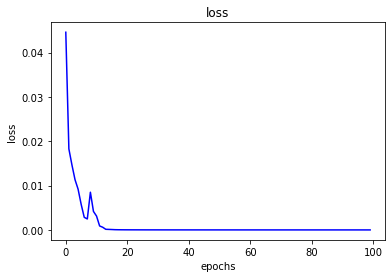

Sentence:  tom found n1 seashells on the beach . he gave jessica n2 of the
seashells . how many seashells does he now have ?
Equation:  x=n1-n2
Prediction:  n1-x=n2

Sentence:  sandy had 36.0 pennies and n1 nickels in her bank . her dad borrowed
20 nickels from sandy . how many nickels does she have now ?
Equation:  x=n1-n2
Prediction:  x=n1+n2

Sentence:  the richmond tigers sold a total of n1 tickets last season . if they sold n2 tickets in the first half of the season , how many tickets did
they sell in the second half ?
Equation:  x=n1-n2
Prediction:  x=n1+n2

Sentence:  melanie bought a batman game for $ n1 , a strategy game for $ 7.90
, and a superman game for $ n3 . melanie already owns 4.0 games . how much did melanie spend on video games ?
Equation:  x=n1+n2+n3
Prediction:  x=n1+n2+n3

Sentence:  joan purchased a basketball game for $ n1 , and a racing game for $
4.23 . how much did joan spend on video games ?
Equation:  x=n1+n2
Prediction:  x=n1+n2

Sentence:  dina made cooki

In [9]:
#HyperParemeters
units = 256#[32, 64, 128, 256, 512, 1024, 2048]
learning_rate = 0.01 #[0.01, 0.03, 0.05, 0.07]
BATCH_SIZE = 4 #[1, 2, 3, 4]
EPOCHS = 100
embedding_dim = 2048 #[512, 1024, 2048, 4096, 8192, 16384]
dropout = 1
#min train loss 0.00000097 con units256, lr0.01, bs4, ed2048, epochs100, dropoutEnDec0.5
best = [[256], [0.01], [4]]




for (units, learning_rate, BATCH_SIZE) in list(itertools.product(*best)):
    encoder = GRUEncoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)
    decoder = GRUDecoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dropout)
    optimizer, loss_object = setOptimizer(learning_rate)
    
    
    checkpoint = tryTheModel(units, learning_rate, BATCH_SIZE, EPOCHS, embedding_dim)

## Manual testing

In [24]:
sentence = 'sara had 100.0 pennies and n1 quarters in her bank . her dad borrowed n2 quarters from sara . how many quarters does she have now ?'
#sentence = 'what is 100 plus 100'
checkpoint.restore(tf.train.latest_checkpoint('./training_checkpoints'))
result, sentence = val(sentence.split(' '))
print(' '.join(sentence))
print('Equation predicted: ', ''.join(seq2text(result, targ_lang_index2word)[:-1]))

sara had 100.0 pennies and n1 quarters in her bank . her dad borrowed n2 quarters from sara . how many quarters does she have now ?
Equation predicted:  x=n1-n2
